!python -m spacy download en_core_web_sm

In [1]:
from IPython.core.display import display

import pandas as pd
pd.set_option('display.max_columns',100, 'display.max_colwidth',1000, 'display.max_rows',1000, 
              'display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from datetime import datetime

#import sparknlp
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[4]")\
    .config("spark.driver.memory","4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()

from sparknlp.pretrained import PretrainedPipeline

from pyspark.sql.functions import from_unixtime, unix_timestamp, to_date, year, size, udf, explode, split, col, length, rank, dense_rank, avg, array, row_number, expr, when, sum,lower
from pyspark.sql import functions as f

from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, NGram
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StringType

from pyspark.sql import functions as F
from pyspark.sql.window import Window

import multiprocessing
import geopandas

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud

import spacy

from textblob import TextBlob

:: loading settings :: url = jar:file:/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests/nlp_env/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/javiermartinez/.ivy2/cache
The jars for the packages stored in: /Users/javiermartinez/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b717a228-c506-4fea-87f6-eb729fa9ffbd;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.11;2.4.5 in central
	found com.typesafe#config;1.3.0 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found org.apache.hadoop#hadoop-aws;3.2.0 in central
	found com.amazonaws#aws-java-sdk-core;1.11.603 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.9 in central
	found org.apache.httpcomponents#httpcore;4.4.11 in central
	found commons-codec#commons-codec;1.11 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazona

In [2]:
schema = "polarity FLOAT, id LONG, date_time TIMESTAMP, query STRING, user STRING, text STRING"
timestampformat = "EEE MMM dd HH:mm:ss zzz yyyy"


OUT_PATH = "./trainingandtestdata/data"

# file 2: training.1600000.processed.noemoticon.csv
TRAININGDATA_PATH = "./trainingandtestdata/training.1600000.processed.noemoticon.csv"
spark_reader = spark.read.schema(schema)


data = spark_reader.csv(
    TRAININGDATA_PATH,
    quote='"',
    header=False,
    #inferSchema=True,
    columnNameOfCorruptRecord="corrupt_data",
).cache()

In [3]:
# Count of data
print(f"Overall data count: {data.count()}")

# Data summary
display(data.summary().toPandas())
print("Data schema")
data.printSchema()

# Let's look at 50 rows of data
display(data.limit(50).toPandas())


Overall data count: 1600000


,summary,polarity,id,query,user,text
0,count,1600000,1600000,1600000,1600000,1600000
1,mean,2.0,1.9988175522956276E9,None,4.325887521835714E9,None
2,stddev,2.000000625000293,1.935760736226641E8,None,5.162733218454889E10,None
3,min,0.0,1467810369,NO_QUERY,000catnap000,exhausted
4,25%,0.0,1956910873,None,32508.0,None
5,50%,0.0,2002096238,None,130587.0,None
6,75%,4.0,2177061550,None,1100101.0,None
7,max,4.0,2329205794,NO_QUERY,zzzzeus111,�����ߧ�ǿ�����ж�؜��� &lt;&lt;----I DID NOT KNOW I CUD or HOW TO DO ALL DAT ON MY PHONE TIL NOW. WOW..MY LIFE IS NOW COMPLETE. JK.


Data schema
root
 |-- polarity: float (nullable = true)
 |-- id: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



,polarity,id,date_time,query,user,text
0,0.00,1467810369,NaT,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0.00,1467810672,NaT,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0.00,1467810917,NaT,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0.00,1467811184,NaT,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0.00,1467811193,NaT,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0.00,1467811372,NaT,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0.00,1467811592,NaT,NO_QUERY,mybirch,Need a hug
7,0.00,1467811594,NaT,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0.00,1467811795,NaT,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0.00,1467812025,NaT,NO_QUERY,mimismo,@twittera que me muera ?


In [43]:
# same positive/negative tweets

polarity_df = data.select("polarity").cache()

polarity_df.groupBy("polarity").count().toPandas()

22/02/01 00:41:11 WARN CacheManager: Asked to cache already cached data.


,polarity,count
0,0.00,800000
1,4.00,800000


/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests/nlp_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

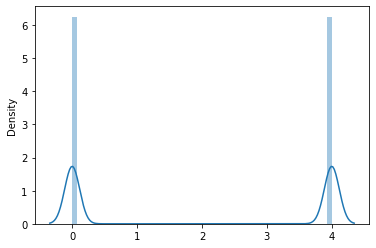

In [35]:
df = data.select("polarity").na.drop()
sns.distplot(df.toPandas())

In [6]:
import html
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.streaming import DataStreamReader
from pyspark.sql import functions as f
from pyspark.ml import PipelineModel
from pyspark.sql.functions import udf

@udf
def html_unescape(s: str):
    if isinstance(s, str):
        return html.unescape(s)
    return s


def clean_data(df: DataFrame):
    url_regex = r"((https?|ftp|file):\/{2,3})+([-\w+&@#/%=~|$?!:,.]*)|(www.)+([-\w+&@#/%=~|$?!:,.]*)"
    email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"
    user_regex = r"(@\w{1,15})"
    
    return (
        df
        
        # Store the original text column in a new column for future reference
        .withColumn("original_text", f.col("text"))
        
        # Remove email addresses, URLs, and user mentions
        .withColumn("text", f.regexp_replace(f.col("text"), url_regex, ""))
        .withColumn("text", f.regexp_replace(f.col("text"), email_regex, ""))
        .withColumn("text", f.regexp_replace(f.col("text"), user_regex, ""))
        .withColumn("text", f.regexp_replace(f.col("text"), "#", " "))
        
        # Unescape any HTML
        .withColumn("text", html_unescape(f.col("text")))
        
        # Remove all numbers, double/multiple spaces, and leading/trailing whitespaces
        .withColumn("text", f.regexp_replace(f.col("text"), "[^a-zA-Z']", " "))
        .withColumn("text", f.regexp_replace(f.col("text"), " +", " "))
        .withColumn("text", f.trim(f.col("text")))
        
        # Ensure we don't end up with empty rows
        .filter(f.col("text") != "").na.drop(subset="text")
    )

data_in = clean_data(data)

data_in.limit(10).toPandas()

Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests/nlp_env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests/nlp_env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests/nlp_env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests/nlp_env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,polarity,id,date_time,query,user,text,original_text
0,0.00,1467810369,NaT,NO_QUERY,_TheSpecialOne_,A that's a bummer You shoulda got David Carr of Third Day to do it D,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0.00,1467810672,NaT,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it and might cry as a result School today also Blah,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0.00,1467810917,NaT,NO_QUERY,mattycus,I dived many times for the ball Managed to save The rest go out of bounds,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0.00,1467811184,NaT,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0.00,1467811193,NaT,NO_QUERY,Karoli,no it's not behaving at all i'm mad why am i here because I can't see you all over there,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0.00,1467811372,NaT,NO_QUERY,joy_wolf,not the whole crew,@Kwesidei not the whole crew
6,0.00,1467811592,NaT,NO_QUERY,mybirch,Need a hug,Need a hug
7,0.00,1467811594,NaT,NO_QUERY,coZZ,hey long time no see Yes Rains a bit only a bit LOL I'm fine thanks how's you,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0.00,1467811795,NaT,NO_QUERY,2Hood4Hollywood,nope they didn't have it,@Tatiana_K nope they didn't have it
9,0.00,1467812025,NaT,NO_QUERY,mimismo,que me muera,@twittera que me muera ?


In [4]:
data_model = data_in.select("text", "polarity").coalesce(3).cache()

In [5]:
(training_data, validation_data, test_data) = data_model.randomSplit([0.98, 0.01, 0.01], seed=2022)

In [ ]:
%%time
from pyspark.ml.feature import (
    StopWordsRemover,
    Tokenizer,
    HashingTF,
    IDF,
)


from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import NGram

tokenizer = Tokenizer(inputCol="text", outputCol="words1")
stopwords_remover = StopWordsRemover(
    inputCol="words1",
    outputCol="words2",
    stopWords=StopWordsRemover.loadDefaultStopWords("english")
)

#ngrams = NGram(
#    n=3,
#    inputCol="words2",
#    outputCol="words3")

hashing_tf = HashingTF(
    inputCol="words2",
    outputCol="term_frequency",
)
idf = IDF(
    inputCol="term_frequency",
    outputCol="features",
    minDocFreq=5,
)
lr = LogisticRegression(labelCol="polarity")
#rf = RandomForestClassifier(featuresCol='features',labelCol="polarity")

semantic_analysis_pipeline = Pipeline(
    stages=[tokenizer, stopwords_remover, ngrams, hashing_tf, idf, lr]
)

semantic_analysis_model = semantic_analysis_pipeline.fit(training_data)

In [18]:
%%time 
trained_df = semantic_analysis_model.transform(training_data)
val_df = semantic_analysis_model.transform(validation_data)
test_df = semantic_analysis_model.transform(test_data)

CPU times: user 150 ms, sys: 53 ms, total: 203 ms
Wall time: 620 ms


In [19]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="polarity", metricName="accuracy")

accuracy_val = evaluator.evaluate(val_df)
accuracy_test = evaluator.evaluate(test_df)
print("Validation Data:")
print(f"Accuracy: {accuracy_val*100:.5f}%")
print("Testing Data:")
print(f"Accuracy: {accuracy_test*100:.5f}%")

22/02/02 18:17:12 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/02 18:17:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


Validation Data:
Accuracy: 76.96612%
Testing Data:
Accuracy: 77.58224%
CPU times: user 21.3 ms, sys: 8.92 ms, total: 30.2 ms
Wall time: 11 s


In [16]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="polarity", metricName="accuracy")

accuracy_val = evaluator.evaluate(val_df)
accuracy_test = evaluator.evaluate(test_df)
print("Validation Data:")
print(f"Accuracy: {accuracy_val*100:.5f}%")
print("Testing Data:")
print(f"Accuracy: {accuracy_test*100:.5f}%")

22/02/02 18:01:40 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/02/02 18:01:42 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


Validation Data:
Accuracy: 53.74992%
Testing Data:
Accuracy: 54.33120%
CPU times: user 26.4 ms, sys: 13.6 ms, total: 39.9 ms
Wall time: 3.49 s


In [ ]:
%%time
final_model = semantic_analysis_pipeline.fit(data_model)

accuracy_test = evaluator.evaluate(final_model.transform(test_data))
print(f"Accuracy: {accuracy_test*100:.5f}%")

In [19]:
final_model.write().overwrite().save(OUT_PATH)

22/01/24 19:06:51 WARN TaskSetManager: Stage 157 contains a task of very large size (4184 KiB). The maximum recommended task size is 1000 KiB.
22/01/24 19:06:53 WARN TaskSetManager: Stage 161 contains a task of very large size (3435 KiB). The maximum recommended task size is 1000 KiB.


#### We have the model and we are going to inspect twitter data

# COP26

Unimos todos los ficheros

In [3]:
import os
import glob
import pandas as pd
os.chdir("./COP26")

In [10]:
extension = 'csv'
all_filenames = sorted([i for i in glob.glob('*.{}'.format(extension))])

In [11]:
all_filenames

['data_20211030.csv',
 'data_20211031.csv',
 'data_20211101.csv',
 'data_20211102.csv',
 'data_20211103.csv',
 'data_20211104.csv',
 'data_20211105.csv',
 'data_20211106.csv',
 'data_20211107.csv',
 'data_20211108.csv',
 'data_20211109.csv',
 'data_20211110.csv',
 'data_20211111.csv',
 'data_20211112.csv',
 'data_20211113.csv',
 'data_20211114.csv',
 'data_20211115.csv',
 'data_20211116.csv']

In [18]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "./all_COP26.csv", index=False, encoding='utf-8-sig')

/var/folders/cq/chz9zg6x10g5bz4tw4mdmd840000gn/T/ipykernel_8135/4218146466.py:2: DtypeWarning: Columns (0,3,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])


FileNotFoundError: [Errno 2] No such file or directory: './COP26/all_COP26.csv'

In [20]:
tweets = spark.read.csv('./COP26/all_COP26.csv').repartition(12).persist()

In [21]:
tweets.count()

10388205

In [22]:
tweets.unpersist()

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string]

In [83]:
from pyspark.sql import functions as f

# Focus on the tweets that got at least 2 retweets, to try to take out bots and trash accounts
tw = (tweets
        .filter("lang = 'en'")
        .filter(f.col('retweetCount')>2)
        .withColumn('text',f.lower(f.col('content'))))

In [84]:
tw.count()

54779

In [85]:
influencers = (tw      
    .select('user.displayName','user.followersCount')
    .groupBy('displayName')
    .agg(f.max('followersCount'),f.count('displayName'))
    .orderBy('max(followersCount)', ascending=False)
    .withColumnRenamed('max(followersCount)','followers')
    .withColumnRenamed('count(displayName)','#tweets')
              )

tweets.count(), tw.count(), influencers.count()
# take tweets of the 65th quantile of the most followed accounts
# influencers.select(f.percentile_approx("followers", 0.65)).show()

(408060, 54779, 23196)

In [86]:
influencers.limit(10).toPandas()

,displayName,followers,#tweets
0,Barack Obama,130389534,2
1,CNN Breaking News,61729935,2
2,Bill Gates,56360678,1
3,CNN,55546433,26
4,The New York Times,51131817,15
5,BBC Breaking News,48570727,5
6,BBC News (World),33744740,14
7,Shawn Mendes,26724840,1
8,National Geographic,26666577,4
9,The Economist,26069284,56


Filtramos aquellos usuarios con un número de followers inferior al 65th percentile

In [87]:
## filter out users with less followers count than the 65th quantile
follower_limit = influencers.select(f.percentile_approx("followers", 0.65)).rdd.flatMap(lambda x: x).collect()

influencers = influencers.filter(f.col('followers')>=follower_limit[0])

influencer_list = influencers.select("displayName").rdd.flatMap(lambda x: x).collect()
tw = tw.filter(f.col('user.displayName').isin(influencer_list)).cache()



In [110]:
influencers.limit(10).toPandas()

,displayName,followers,#tweets
0,Barack Obama,130389534,2
1,CNN Breaking News,61729935,2
2,Bill Gates,56360678,1
3,CNN,55546433,26
4,The New York Times,51131817,15
5,BBC Breaking News,48570727,5
6,BBC News (World),33744740,14
7,Shawn Mendes,26724840,1
8,National Geographic,26666577,4
9,The Economist,26069284,56


In [109]:
tw.count(), influencers.count()

(28363, 8121)

In [96]:
tw.printSchema()

root
 |-- _type: string (nullable = true)
 |-- cashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- content: string (nullable = true)
 |-- conversationId: long (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- date: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- inReplyToTweetId: long (nullable = true)
 |-- inReplyToUser: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- created: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- descriptionUrls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |  

### Users

In [103]:
users = (
        tw 
        .select('user.displayname','user.followersCount','date') 
        .where(col('user.username').isNotNull())
        )

In [104]:
users.show(2,False)

+-------------------------+--------------+-------------------------+
|displayname              |followersCount|date                     |
+-------------------------+--------------+-------------------------+
|Sebastian Payne          |103939        |2021-11-14T13:00:10+00:00|
|Trevor Phillips on Sunday|93017         |2021-11-14T10:19:58+00:00|
+-------------------------+--------------+-------------------------+
only showing top 2 rows



In [105]:
### Delete emoticons and convert date to date format

# delete emoticons
@udf
def ascii_ignore(x):
    return x.encode('latin-1', 'ignore').decode('latin-1')


users = (users
            .withColumn("user", ascii_ignore('displayname'))
            .withColumn("date", split(col("date"),"T").getItem(0))
            .withColumn('date',to_date("date", "yyyy-MM-dd"))
        )

In [106]:
### group by user 
f = (
    users
        .groupBy("user").count() 
        .withColumnRenamed("count","#tweets") 
        .orderBy('count', ascending=False).limit(20).toPandas().reset_index(drop=True)
    )

In [107]:
f.head()


,user,#tweets
0,Sky News,208
1,Umair A.,144
2,Reuters,137
3,NowThis,123
4,The Independent,117


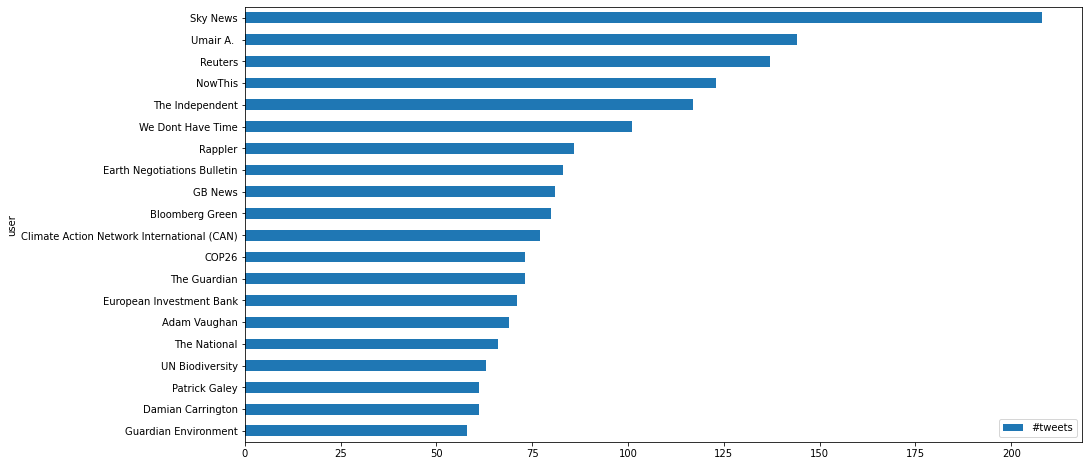

In [108]:
f.sort_values('#tweets', inplace=True)
f.plot.barh(x='user',y='#tweets', figsize=(15, 8));

In [29]:
### group by (user, date)

f_d = users.groupBy("user","date").count() \
        .orderBy('count', ascending=False).toPandas().reset_index(drop=True)

top20_users = f_d.nlargest(20,'count')
top20_users['user'] = pd.Categorical(top20_users.user)

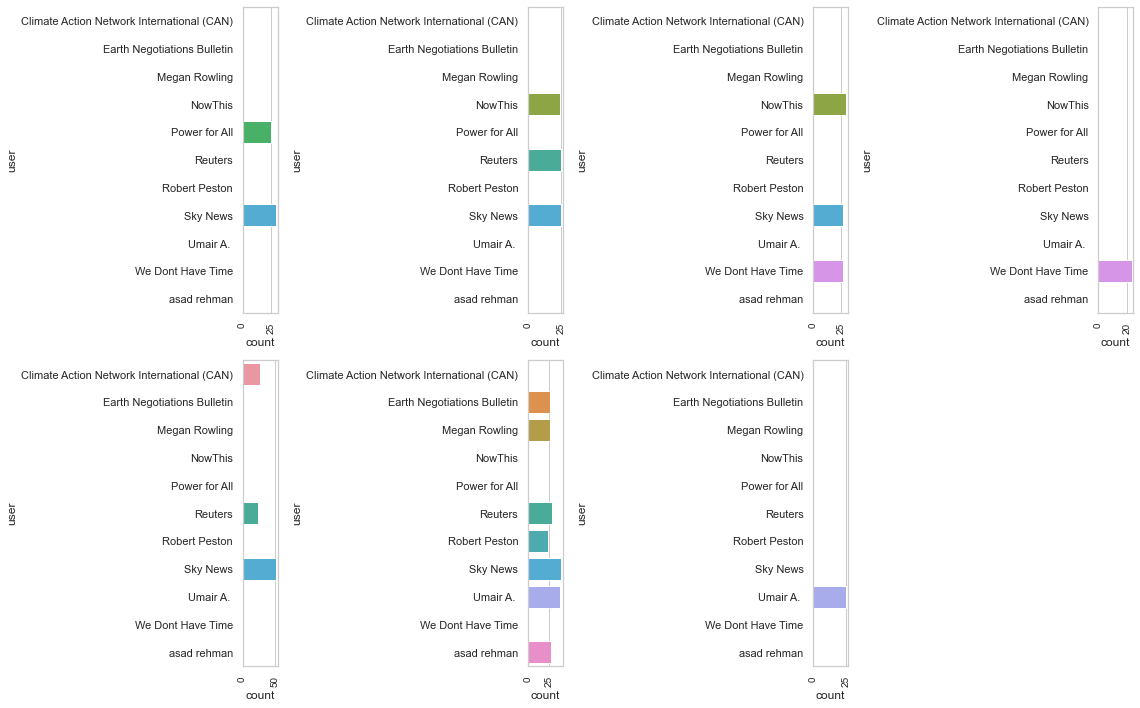

In [93]:
days = list(np.unique(top20_users.date))
plt.figure(figsize=(16,10))
sns.set(style="whitegrid")

for ax_num, day in zip(range(1,8), days):
    plt.subplot(2,4,ax_num)
    sns.barplot(x='count', y='user',
                data=top20_users[top20_users['date'] == day])
    plt.xticks(rotation=90, fontsize=10)
    
plt.tight_layout()

### Tweets per most influential users

In [144]:
from pyspark.sql import Window
w = Window.partitionBy('username').orderBy(col("followersCount").desc())

users = (users
          .withColumn("row",row_number().over(w)) 
          .filter(col("row") == 1).drop("row") 
          .orderBy('followersCount', ascending=False)
          .show()
)

AttributeError: 'NoneType' object has no attribute 'withColumn'

In [ ]:
users.groupBy('username').count().orderBy('count',ascending=True).limit(10).toPandas()

In [120]:
users.withColumn('maxFollowers', f.max('followersCount').over(w))\
    .where(f.col('followersCount') == f.col('maxFollowers'))\
    .drop('maxFollowers')\
    .show()

TypeError: unhashable type: 'list'

In [101]:
influencers = (users2      
    #.select('user','followersCount')
    .groupBy('username','followersCount')
    .agg(f.max('followersCount'))
    .orderBy('max(followersCount)', ascending=False)
    #.withColumnRenamed('max(#followers)','#followers')
    .toPandas()
    )

ValueError: No axis named followersCount for object type DataFrame

### Hashtags

In [33]:
hashtags = (
    tw
    .where(col('hashtags').isNotNull())
    .withColumn("hashtags", explode("hashtags"))
    .select(lower(col('hashtags')).alias('hashtags'),'date') 
)


In [34]:
### Delete emoticons and convert date to date format

hashtags = (
        hashtags
            .withColumn("hashtags", ascii_ignore('hashtags'))
            .withColumn("date", split(col("date"),"T").getItem(0))
            .withColumn('date',to_date("date", "yyyy-MM-dd"))
        )

NameError: name 'ascii_ignore' is not defined

In [36]:
### group by user 
h = (
    hashtags
        .groupBy("hashtags").count() 
        .orderBy('count', ascending=False).toPandas().reset_index(drop=True)
    )

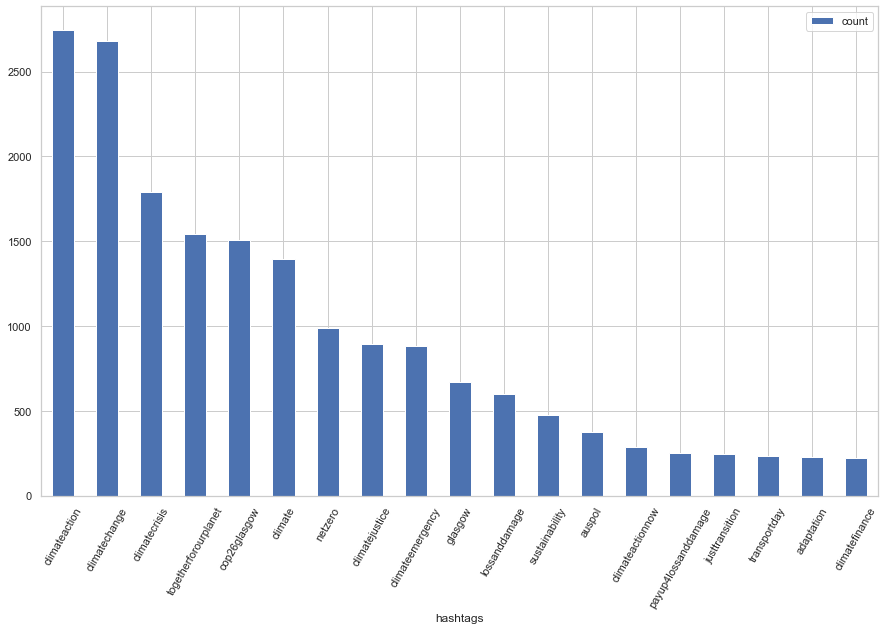

In [38]:
# There are several hashtags that might be filtered. (p.e: cop26, unknown)
h[1:20].plot.bar(x='hashtags',y='count',rot=60, figsize=(15, 9));

In [39]:
### group by (hashtags, date)

h_d = (
        hashtags
            .groupBy("hashtags","date").count() 
            .orderBy('count', ascending=False).toPandas().reset_index(drop=True)
        )

top20_hashtags = h_d.nlargest(20,'count')
top20_hashtags['hashtags'] = pd.Categorical(top20_hashtags.hashtags)

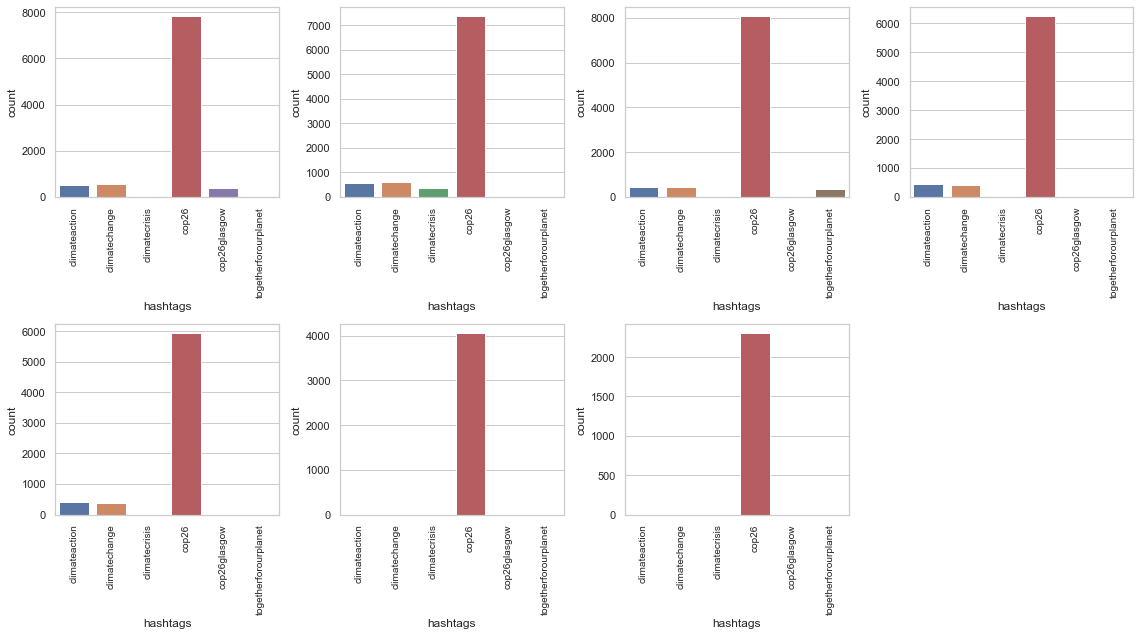

In [41]:
days = list(np.unique(top20_hashtags.date))
plt.figure(figsize=(16,9))
sns.set(style="whitegrid")

for ax_num, day in zip(range(1,8), days):
    plt.subplot(2,4,ax_num)
    sns.barplot(x='hashtags', y='count',
                data=top20_hashtags[top20_hashtags['date'] == day])
    plt.xticks(rotation=90, fontsize=10)
    
plt.tight_layout()

### Mentioned users

In [42]:

m_users = (
        tw
        .where(col("mentionedUsers").isNotNull())
        .withColumn("mentionedUsers", explode("mentionedUsers"))
        .withColumn("date", split(col("date"),"T").getItem(0))
        .withColumn("date",to_date("date", "yyyy-MM-dd"))
        .select(lower(col('mentionedUsers.displayname')).alias('mentionedUsers'),'date')
        .withColumn("mentionedUsers", ascii_ignore(col("mentionedUsers")))
)


In [43]:
### group by user 
m_u = (
        m_users
            .groupBy("mentionedUsers").count() 
            .orderBy('count', ascending=False).toPandas().reset_index(drop=True)
      )

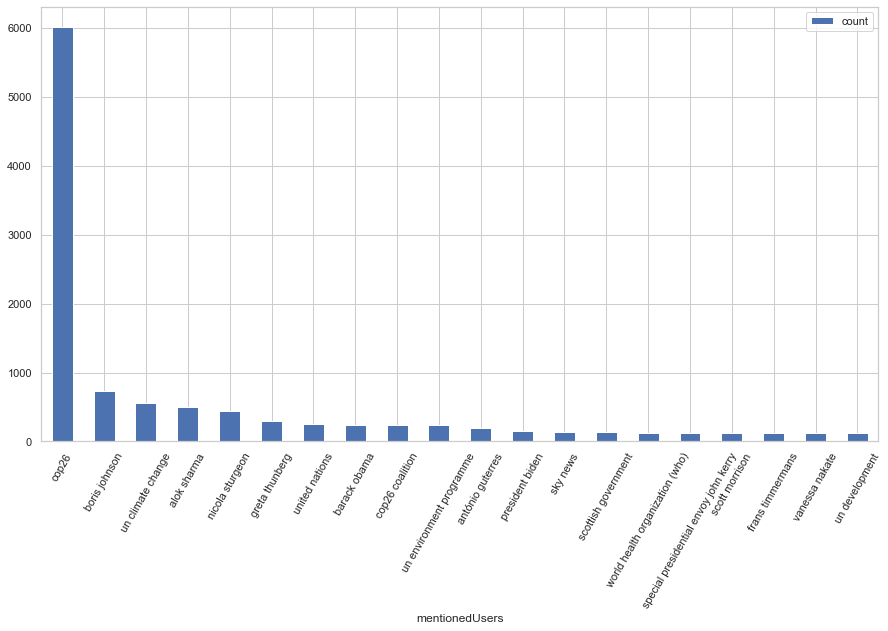

In [45]:
## filter out "COP26" mentioned user
m_u[0:20].plot.bar(x='mentionedUsers',y='count',rot=60, figsize=(15, 8));

In [46]:
### group by (mentioned_user, date)

m_u_d = (
        m_users
            .groupBy("mentionedUsers","date").count() 
            .orderBy('count', ascending=False)
            .toPandas()
            .reset_index(drop=True)
        )

top20_mentioned = m_u_d.nlargest(20,'count')
top20_mentioned['mentionedUsers'] = pd.Categorical(top20_mentioned.mentionedUsers)

In [47]:
top20_mentioned.head()

,mentionedUsers,date,count
0,cop26,2021-11-10,1246
1,cop26,2021-11-08,1171
2,cop26,2021-11-09,1102
3,cop26,2021-11-11,864
4,cop26,2021-11-12,825


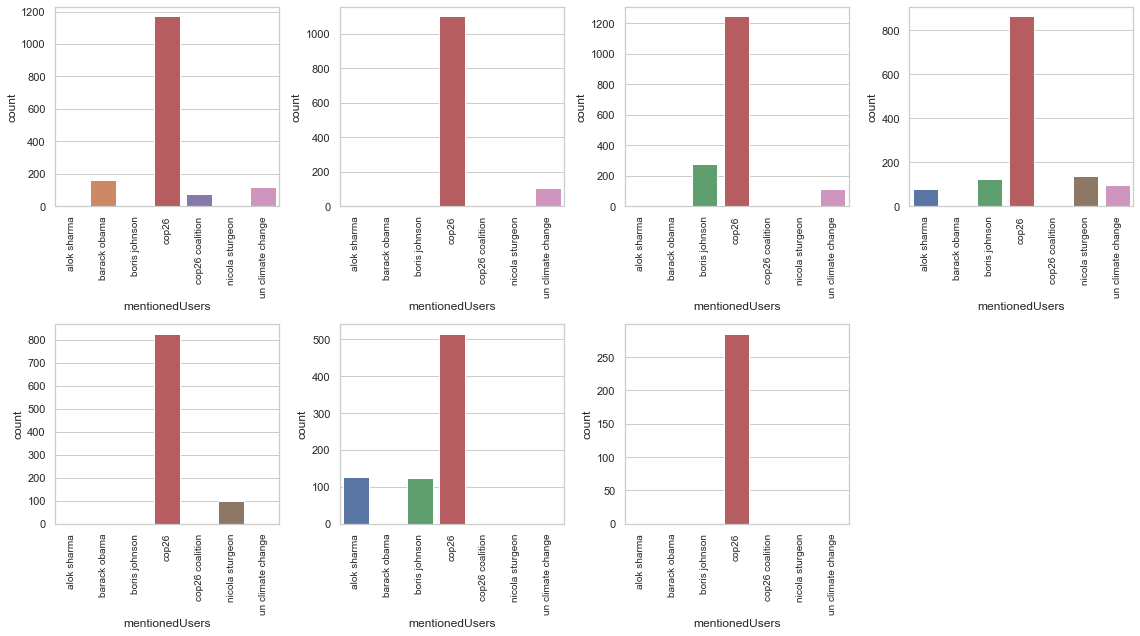

In [49]:
days = list(np.unique(top20_mentioned.date))
plt.figure(figsize=(16,9))
sns.set(style="whitegrid")

for ax_num, day in zip(range(1,8), days):
    plt.subplot(2,4,ax_num)
    sns.barplot(x='mentionedUsers', y='count',
                data=top20_mentioned[top20_mentioned['date'] == day])
    plt.xticks(rotation=90, fontsize=10)
    
plt.tight_layout()

### Country

In [24]:
from pyspark.sql import functions as f
import html

@udf
def html_unescape(s: str):
    return html.unescape(s)


location = (
        tw
        .select(col('place.country').alias('country'),'date')
        .where(col("country")!= "''")
        .withColumn("date", split(col("date"),"T").getItem(0))
        .withColumn("date",to_date("date", "yyyy-MM-dd"))
        # Unescape any HTML
        .withColumn("country", html_unescape(f.col("country")))
        
        # Remove all numbers, double/multiple spaces, and leading/trailing whitespaces
        .withColumn("country", f.regexp_replace(f.col("country"), "[^a-zA-Z']", " "))
        .withColumn("country", f.regexp_replace(f.col("country"), " +", " "))
        .withColumn("country", f.trim(f.col("country")))
        
        # Ensure we don't end up with empty rows
        .filter(f.col("country") != "").na.drop(subset="country")
)



In [25]:
### group by user 
l = (
    location
        .groupBy("country")
        .count() 
        .orderBy('count', ascending=False)
        .toPandas()
        .reset_index(drop=True)
    )

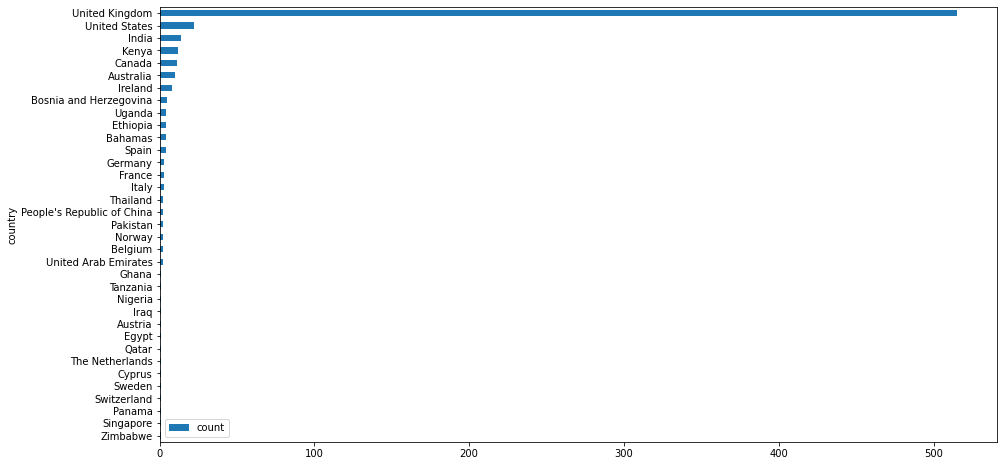

In [27]:
l.sort_values('count', inplace=True)
l.plot.barh(x='country',y='count', figsize=(15, 8));

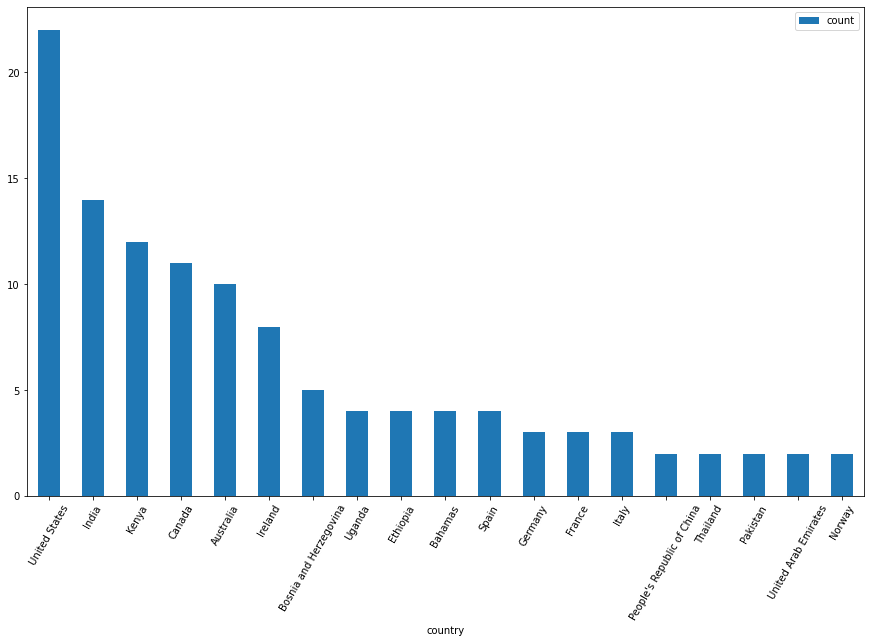

In [26]:
# Filter out UK in #1

l[1:20].plot.bar(x='country',y='count',rot=60, figsize=(15, 9));

### Content analysis

In [48]:
content = (
        tw
        .select(f.lower(f.col('content')).alias('text'),col('place.country').alias('country') )
)

In [16]:
content.show(2,truncate=False)

NameError: name 'content' is not defined

In [35]:
#clean_content = clean_data(content)
clean_content = clean_data(tw)


### Reload our Pre-Trained Model

In [36]:
sentiment_model = PipelineModel.load(OUT_PATH)

In [37]:
raw_sentiment = sentiment_model.transform(clean_content)

In [40]:
# Select downstream columns
sentiment = (raw_sentiment
             .select("original_text","text", f.col("prediction").alias("user_sentiment"), "place.country")
             .filter(f.col("country")!='')
             .withColumn("user_sentiment", f.when((f.col("user_sentiment") == 0.0), f.lit("Negative"))
             .otherwise( f.lit("Positive"))))       
display(sentiment.limit(10).toPandas())

22/02/09 20:34:54 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


,original_text,text,user_sentiment,country
0,"despite all the challenges during and after #cop26,let me appreciate some of the kenyan delegates that spent sleepless nights and put in much effort to see kenya’s 🇰🇪positive influence and visibility felt. many thanks to cs keriako tobiko and ps @kiptoock. time to walk the talk! https://t.co/tyzras0lex",despite all the challenges during and after cop let me appreciate some of the kenyan delegates that spent sleepless nights and put in much effort to see kenya s positive influence and visibility felt many thanks to cs keriako tobiko and ps time to walk the talk,Positive,United Kingdom
1,was an honour co-chairing with outi and the excellent @unfccc finance team the negotiations and finally getting the decision @cop26 on the new collective goal on climate finance. https://t.co/qmcz5kpldx,was an honour co chairing with outi and the excellent finance team the negotiations and finally getting the decision on the new collective goal on climate finance,Positive,United Kingdom
2,"after the failure of #cop26, there is only one last hope for our survival | @georgemonbiot https://t.co/zamrg9ujmx",after the failure of cop there is only one last hope for our survival,Negative,Ireland
3,"nature gives a thumbs down to ""glasgow climate pact"" as nepal's mustang sees an avalanche on the day of the announcement of pact.\n\nps: cop26 prez @aloksharma_rdg had made a mention of jomsom which is in mustang during his opening speech at cop.\nhttps://t.co/eqjgh1ov66",nature gives a thumbs down to glasgow climate pact as nepal's mustang sees an avalanche on the day of the announcement of pact ps cop prez had made a mention of jomsom which is in mustang during his opening speech at cop,Negative,India
4,"lots of monday inbox chat already post #cop26 whether you are an insider or an outsider, public and private finance in every country is the key target for influence, diplomacy, regulation, litigation, activism. time to apply a handbrake turn to the supertanker. imho.",lots of monday inbox chat already post cop whether you are an insider or an outsider public and private finance in every country is the key target for influence diplomacy regulation litigation activism time to apply a handbrake turn to the supertanker imho,Negative,United Kingdom
5,"i got angry recording the first bit to this — just listen to what the car execs from gm, ford and volvo said at the cop26 transport plenary. they were brazenly there to sell cars and suck up subsidies! “infrastructure, infrastructure, infrastructure!” demanded the ford exec.",i got angry recording the first bit to this just listen to what the car execs from gm ford and volvo said at the cop transport plenary they were brazenly there to sell cars and suck up subsidies infrastructure infrastructure infrastructure demanded the ford exec,Negative,United Kingdom
6,"cop26 was a crucial step, but not enough. 1.5 degrees celsius remains within reach - but the work is far from done. we must move faster toward a cleaner future for our planet. road from glasgow is more action - 50% targets for 2030 &amp; net-zero by 2050 plus nature based solutions. https://t.co/fdgp0bsqni",cop was a crucial step but not enough degrees celsius remains within reach but the work is far from done we must move faster toward a cleaner future for our planet road from glasgow is more action targets for net zero by plus nature based solutions,Positive,Switzerland
7,#cop26\n\nconvention services have sent a signal - heating off and getting quite chilly in the plenary overflow room https://t.co/1zn8p1fzts,cop convention services have sent a signal heating off and getting quite chilly in the plenary overflow room,Positive,United Kingdom
8,pacific negotiator in #cop26 call out australia and new zealand for non-support of pacific sids positions. #pacific #climateaction #climatejustice,pacific negotiator in cop call out australia and new zealand for non support of pacific sids positions pacific climateaction

22/02/10 12:06:26 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/10 12:06:30 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/10 12:06:30 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/10 12:06:31 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


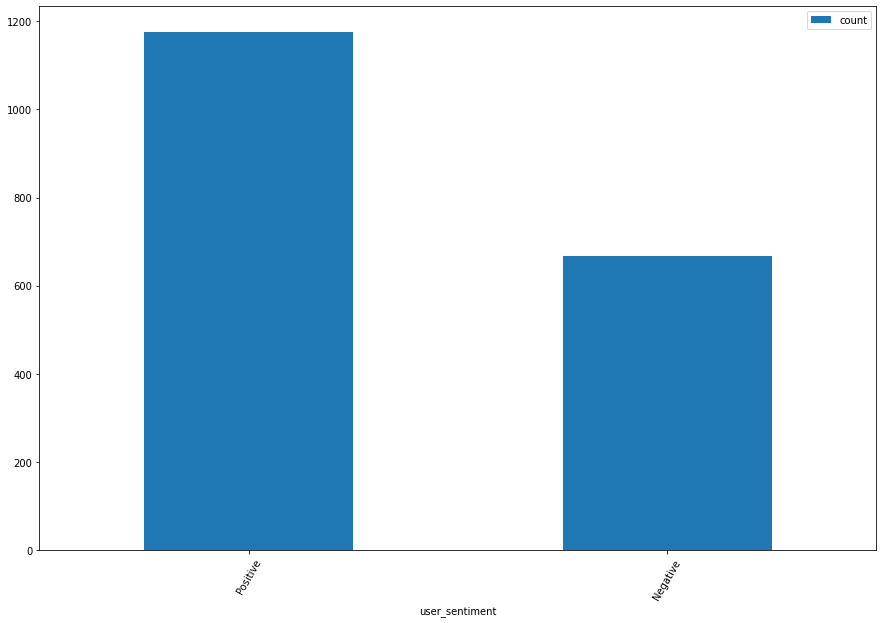

In [58]:
(sentiment
    .groupBy("user_sentiment").count()
    .orderBy('count', ascending=False)
    .toPandas()
    .reset_index(drop=True)
    .plot.bar(x='user_sentiment',y='count',rot=60, figsize=(15, 10)));


In [42]:
a = (sentiment
    .select('country','user_sentiment')
    .groupBy('country','user_sentiment')
    .count()
    .orderBy('country')
    #.limit(10)
    .toPandas())


22/02/09 20:35:11 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/09 20:35:13 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/09 20:35:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/09 20:35:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


In [43]:
sentiment.limit(10).toPandas()

22/02/09 20:35:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


,original_text,text,user_sentiment,country
0,"despite all the challenges during and after #cop26,let me appreciate some of the kenyan delegates that spent sleepless nights and put in much effort to see kenya’s 🇰🇪positive influence and visibility felt. many thanks to cs keriako tobiko and ps @kiptoock. time to walk the talk! https://t.co/tyzras0lex",despite all the challenges during and after cop let me appreciate some of the kenyan delegates that spent sleepless nights and put in much effort to see kenya s positive influence and visibility felt many thanks to cs keriako tobiko and ps time to walk the talk,Positive,United Kingdom
1,was an honour co-chairing with outi and the excellent @unfccc finance team the negotiations and finally getting the decision @cop26 on the new collective goal on climate finance. https://t.co/qmcz5kpldx,was an honour co chairing with outi and the excellent finance team the negotiations and finally getting the decision on the new collective goal on climate finance,Positive,United Kingdom
2,"after the failure of #cop26, there is only one last hope for our survival | @georgemonbiot https://t.co/zamrg9ujmx",after the failure of cop there is only one last hope for our survival,Negative,Ireland
3,"nature gives a thumbs down to ""glasgow climate pact"" as nepal's mustang sees an avalanche on the day of the announcement of pact.\n\nps: cop26 prez @aloksharma_rdg had made a mention of jomsom which is in mustang during his opening speech at cop.\nhttps://t.co/eqjgh1ov66",nature gives a thumbs down to glasgow climate pact as nepal's mustang sees an avalanche on the day of the announcement of pact ps cop prez had made a mention of jomsom which is in mustang during his opening speech at cop,Negative,India
4,"lots of monday inbox chat already post #cop26 whether you are an insider or an outsider, public and private finance in every country is the key target for influence, diplomacy, regulation, litigation, activism. time to apply a handbrake turn to the supertanker. imho.",lots of monday inbox chat already post cop whether you are an insider or an outsider public and private finance in every country is the key target for influence diplomacy regulation litigation activism time to apply a handbrake turn to the supertanker imho,Negative,United Kingdom
5,"i got angry recording the first bit to this — just listen to what the car execs from gm, ford and volvo said at the cop26 transport plenary. they were brazenly there to sell cars and suck up subsidies! “infrastructure, infrastructure, infrastructure!” demanded the ford exec.",i got angry recording the first bit to this just listen to what the car execs from gm ford and volvo said at the cop transport plenary they were brazenly there to sell cars and suck up subsidies infrastructure infrastructure infrastructure demanded the ford exec,Negative,United Kingdom
6,"cop26 was a crucial step, but not enough. 1.5 degrees celsius remains within reach - but the work is far from done. we must move faster toward a cleaner future for our planet. road from glasgow is more action - 50% targets for 2030 &amp; net-zero by 2050 plus nature based solutions. https://t.co/fdgp0bsqni",cop was a crucial step but not enough degrees celsius remains within reach but the work is far from done we must move faster toward a cleaner future for our planet road from glasgow is more action targets for net zero by plus nature based solutions,Positive,Switzerland
7,#cop26\n\nconvention services have sent a signal - heating off and getting quite chilly in the plenary overflow room https://t.co/1zn8p1fzts,cop convention services have sent a signal heating off and getting quite chilly in the plenary overflow room,Positive,United Kingdom
8,pacific negotiator in #cop26 call out australia and new zealand for non-support of pacific sids positions. #pacific #climateaction #climatejustice,pacific negotiator in cop call out australia and new zealand for non support of pacific sids positions pacific climateaction

In [44]:
a.head()

,country,user_sentiment,count
0,Australia,Negative,12
1,Australia,Positive,15
2,Austria,Negative,1
3,Austria,Positive,1
4,Bahamas,Negative,3


In [45]:
b = (sentiment
    .select('country','user_sentiment')
    .groupBy('country')
    .count()
    .orderBy('country')
    #.limit(10)
    .toPandas())


In [79]:
b.head()

,country,count
0,Australia,27
1,Austria,2
2,Bahamas,4
3,Bangladesh,8
4,Belgium,4


In [47]:
#a.join(b, on='country',how='left',lsuffix='_a', rsuffix='_b')

DF = pd.merge(a, b, on=['country'])

In [49]:
DF.head(10)

,country,user_sentiment,count_x,count_y
0,Australia,Negative,12,27
1,Australia,Positive,15,27
2,Austria,Negative,1,2
3,Austria,Positive,1,2
4,Bahamas,Negative,3,4
5,Bahamas,Positive,1,4
6,Bangladesh,Negative,7,8
7,Bangladesh,Positive,1,8
8,Belgium,Positive,3,4
9,Belgium,Negative,1,4


In [50]:
DF['ratio'] = DF['count_x']/DF['count_y']

In [51]:
DF.head(10)

,country,user_sentiment,count_x,count_y,ratio
0,Australia,Negative,12,27,0.44
1,Australia,Positive,15,27,0.56
2,Austria,Negative,1,2,0.50
3,Austria,Positive,1,2,0.50
4,Bahamas,Negative,3,4,0.75
5,Bahamas,Positive,1,4,0.25
6,Bangladesh,Negative,7,8,0.88
7,Bangladesh,Positive,1,8,0.12
8,Belgium,Positive,3,4,0.75
9,Belgium,Negative,1,4,0.25


In [52]:
DF = DF.drop_duplicates(subset=['country'])

In [53]:
DF.head(10)

,country,user_sentiment,count_x,count_y,ratio
0,Australia,Negative,12,27,0.44
2,Austria,Negative,1,2,0.50
4,Bahamas,Negative,3,4,0.75
6,Bangladesh,Negative,7,8,0.88
8,Belgium,Positive,3,4,0.75
10,Bosnia and Herzegovina,Negative,2,5,0.40
12,Brazil,Positive,1,1,1.00
13,Brunei,Positive,1,1,1.00
14,Cambodia,Positive,1,1,1.00
15,Canada,Positive,15,22,0.68


In [54]:
DF['ratio_positive'] = np.where(DF['user_sentiment']== 'Positive', DF['ratio'], 1 - DF['ratio'])

In [55]:
DF.head(10)

,country,user_sentiment,count_x,count_y,ratio,ratio_positive
0,Australia,Negative,12,27,0.44,0.56
2,Austria,Negative,1,2,0.50,0.50
4,Bahamas,Negative,3,4,0.75,0.25
6,Bangladesh,Negative,7,8,0.88,0.12
8,Belgium,Positive,3,4,0.75,0.75
10,Bosnia and Herzegovina,Negative,2,5,0.40,0.60
12,Brazil,Positive,1,1,1.00,1.00
13,Brunei,Positive,1,1,1.00,1.00
14,Cambodia,Positive,1,1,1.00,1.00
15,Canada,Positive,15,22,0.68,0.68


In [56]:
DF = DF[['country','ratio_positive']].reset_index(drop=True)

In [57]:
DF.head(10)

,country,ratio_positive
0,Australia,0.56
1,Austria,0.50
2,Bahamas,0.25
3,Bangladesh,0.12
4,Belgium,0.75
5,Bosnia and Herzegovina,0.60
6,Brazil,1.00
7,Brunei,1.00
8,Cambodia,1.00
9,Canada,0.68


<AxesSubplot:>

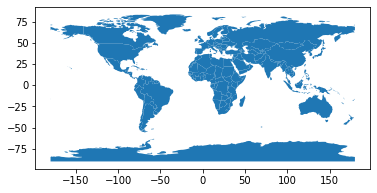

In [18]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot()

In [192]:
import pycountry


countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    
DF['country_codes'] = [countries.get(country, 'Unknown code') for country in DF.country]

In [198]:
DF.loc[DF['country']=='Brunei','country_codes'] = 'BRN'
DF.loc[DF['country']=='Islamic Republic of Iran','country_codes'] = 'IRN'
DF.loc[DF['country']=='Kingdom of Saudi Arabia','country_codes'] = 'SAU'
DF.loc[DF['country']=="People's Republic of China",'country_codes'] = 'CHN'
DF.loc[DF['country']=='Republic of the Philippines','country_codes'] = 'PHL'
DF.loc[DF['country']=='Tanzania','country_codes'] = 'TZA'
DF.loc[DF['country']=='The Netherlands','country_codes'] = 'NLD'

In [199]:
DF.loc[DF['country_codes']=='Unknown code']

,country,ratio_positive,country_codes


In [208]:
DF['iso_a3'] = DF['country_codes']

In [211]:
DF.drop('country_codes',axis=1,inplace=True)

In [241]:
DF_merge = pd.merge(world,DF,how='left',on="iso_a3")

In [242]:
world.shape, DF_merge.shape

((177, 6), (177, 8))

In [17]:
DF_merge.isnull().sum()

NameError: name 'DF_merge' is not defined

In [235]:
DF_merge = DF_merge.fillna({'ratio_positive': 0.5, 'country': ''})

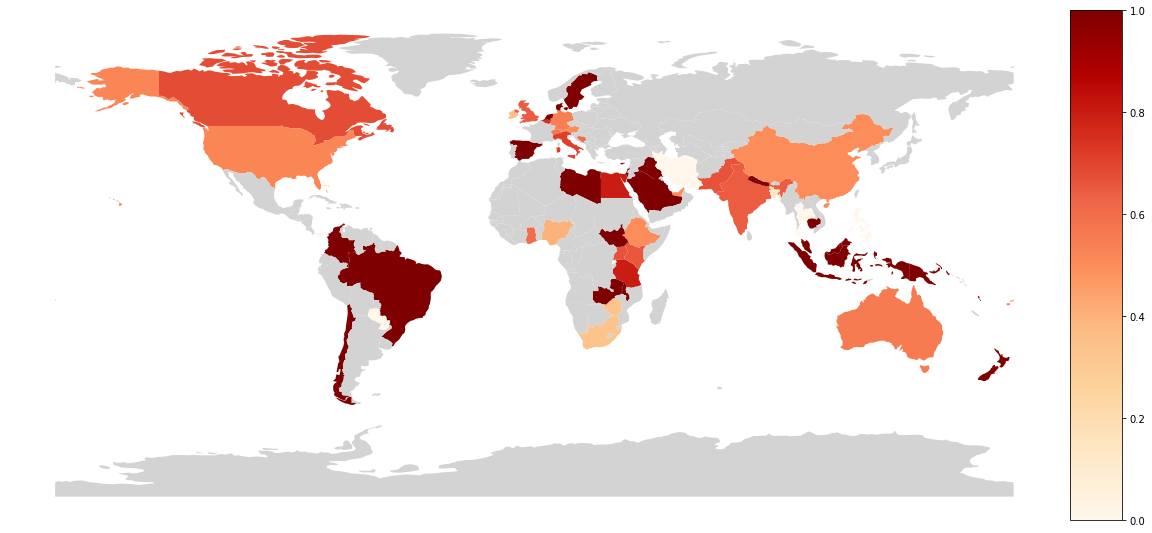

In [256]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(20,15))
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


DF_merge.plot(column='ratio_positive', 
              ax=ax, 
              cax=cax,
              legend=True,cmap='OrRd', 
              #scheme='quantiles',
              missing_kwds={'color': 'lightgrey'},
              
);
ax.axis('off');

### Sentiment timeline

In [10]:
# Select downstream columns
sentiment_timeline = (raw_sentiment
                     .select("date", f.col("prediction").alias("user_sentiment"))
                     .withColumn("date", split(col("date"),"T").getItem(0))
                     .withColumn("date",to_date("date", "yyyy-MM-dd"))
                     .withColumn("user_sentiment", f.when((f.col("user_sentiment") == 0.0), f.lit("Negative"))
                     .otherwise( f.lit("Positive"))))


In [11]:
sentiment_timeline.limit(10).toPandas()

22/02/03 21:03:13 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


,date,user_sentiment
0,2021-11-14,Positive
1,2021-11-14,Negative
2,2021-11-14,Positive
3,2021-11-14,Positive
4,2021-11-14,Negative
5,2021-11-14,Negative
6,2021-11-14,Negative
7,2021-11-14,Negative
8,2021-11-14,Positive
9,2021-11-14,Positive


In [12]:
st = (sentiment_timeline
         .groupBy('date')
         .pivot("user_sentiment")
         .count()
         .orderBy(["date"])
         .toPandas()
)

22/02/03 21:03:16 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/03 21:03:49 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/03 21:03:49 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/03 21:03:49 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/03 21:04:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/03 21:04:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/03 21:04:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/03 21:04:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


In [13]:
st.head()

,date,Negative,Positive
0,2021-11-08,3888,6049
1,2021-11-09,3382,6005
2,2021-11-10,4086,6199
3,2021-11-11,3064,4887
4,2021-11-12,3340,4549


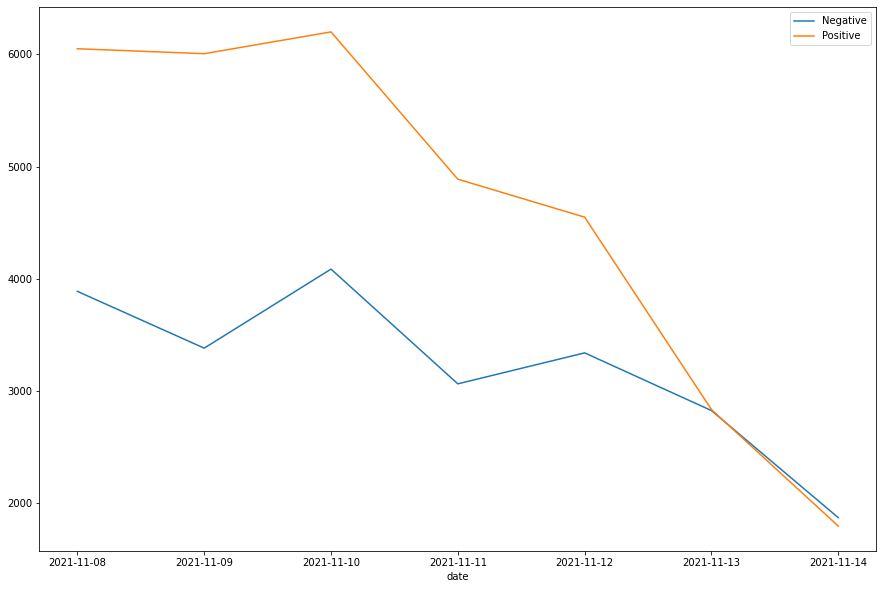

In [19]:
final_df = st.set_index('date')
final_df[['Negative', 'Positive']].plot(figsize=(15,10))
plt.show()


#st.plot.line(x="date", y="count", color='user_sentiment',rot=60)

In [268]:
(sentiment_timeline
     .groupBy('date')
     .count()
     .limit(10)
     .orderBy("date")
     .toPandas()
)

,date,count
0,2021-11-08,9937
1,2021-11-09,9387
2,2021-11-10,10285
3,2021-11-11,7951
4,2021-11-12,7889
5,2021-11-13,5661
6,2021-11-14,3669


#### Vader sentiment

In [56]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/javiermartinez/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [42]:
from pyspark.sql.types import FloatType

@udf
def polaris(s: str):
    return sid.polarity_scores(s)

user_regex = r"(@\w{1,15})"

sentiment_grade =(
    sentiment 
        .withColumn("polarity_vader", polaris(f.col("text")))
        .withColumn("compound", f.regexp_extract(f"polarity_vader", "(compound=)([-+]?\d+(?:,\d+)?(?:\.\d+))", 2))
        .withColumn("compound",f.col("compound").cast(FloatType()))
        .withColumn("user_sentiment_vader", f.when((f.col("compound") < -0.5), f.lit("Negative"))
            .otherwise(f.when((f.col("compound") > 0.5) , f.lit("Positive")).otherwise(f.lit("Neutral")))
        )       
        .withColumn("user_sentiment", f.when((f.col("user_sentiment") == 0.00), f.lit("Negative"))
            .otherwise(f.lit("Positive"))
        )
        .select('original_text','text','user_sentiment','user_sentiment_vader')
    )
     

In [44]:
sentiment_grade.show(2)

22/02/02 19:51:54 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/02/02 19:51:54 ERROR Executor: Exception in task 0.0 in stage 313.0 (TID 772)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/var/folders/cq/chz9zg6x10g5bz4tw4mdmd840000gn/T/ipykernel_45643/53908543.py", line 5, in polaris
NameError: name 'sid' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:86)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.sca

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/var/folders/cq/chz9zg6x10g5bz4tw4mdmd840000gn/T/ipykernel_45643/53908543.py", line 5, in polaris
NameError: name 'sid' is not defined


.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
22/02/02 19:51:54 WARN TaskSetManager: Lost task 0.0 in stage 313.0 (TID 772) (mbp-de-javier.home executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/var/folders/cq/chz9zg6x10g5bz4tw4mdmd840000gn/T/ipykernel_45643/53908543.py", line 5, in polaris
NameError: name 'sid' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:86)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:6

### Sentiment by Country

In [58]:
#function to convert to alpah2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

@udf
def get_country_code(col: str):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    return cn_a2_code

@udf
def get_continent_code(col: str):
    try:
        cn_continent = country_alpha2_to_continent_code(col)
    except:
        cn_continent = 'Unknown' 
    return cn_continent

In [59]:
z = (
    sentiment
    .withColumn('country_code', get_country_code(f.col('country')))
    .withColumn('continent_code', get_continent_code(f.col('country_code')))
)


In [60]:
#function to get longitude and latitude data from country name
from geopy.geocoders import Nominatim

#geolocator = Nominatim(user_agent="http")

    
@udf(returnType='STRUCT<`Latitude`: double, `Longitude`: double>')
def geolocate(country):
    geolocator = Nominatim(user_agent="http")
    try:
        location = geolocator.geocode(query={'country': country}, timeout=60)
        # Geolocate the center of the country
        #loc = geolocator.geocode(country)
        # And return latitude and longitude
        return {'Latitude': location.latitude, 'Longitude': location.longitude}
    except:
        # Return missing value
        return {'Latitude': None, 'Longitude': None}

In [63]:
df = (
    z
    .withColumn('geolocated', geolocate(f.col('country')))
    .select('original_text','text','user_sentiment','country',
            'country_code','continent_code','geolocated.Latitude','geolocated.Longitude')
    .toPandas()
)


22/01/24 19:11:48 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


In [64]:
c = df.groupby('country_code')['text'].count().reset_index()
d = df.groupby('country_code')['user_sentiment'].sum().reset_index()

merged = c.merge(d, left_on = 'country_code', right_on = 'country_code')

merged['percentage'] = merged['user_sentiment']/(merged['text']*4)

merged2 = merged.merge(df, left_on = 'country_code', right_on = 'country_code' )

In [66]:
#We must to convert to .json 

import json
#Read data to json.
merged_json = json.loads(merged2.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

There is some kind of problem with the browser because it is not be able to render this plot

In [67]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, reset_output
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.resources import INLINE
import pandas_bokeh

reset_output()
#
output_notebook()
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest positive sentiment.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40)
#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Sentiment by Country in COP26', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'percentage', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
#p.add_layout(color_bar, 'below')



#Display figure inline in Jupyter Notebook.
#output_notebook("foo.html")

Loading BokehJS ...

GlyphRenderer(id='1043', ...)

In [81]:
import os
os.getcwd()

'/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests'

In [82]:
!pip freeze > requirements.txt

In [68]:
#Display figure. (Display nothing)
show(p,notebook_url="localhost:8888")

In [69]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(df)):
        lat = df.iloc[i]['Latitude']
        long = df.iloc[i]['Longitude']
        radius=5
        popup_text = """Country : {}<br>
                    %of tweets : {}<br>"""
        popup_text = popup_text.format(df.iloc[i]['country'],
                                   df.iloc[i]['user_sentiment']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

In [70]:
import geopandas as gpd
shapefile = './trainingandtestdata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']

#print(gdf[gdf['country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])

gdf.head()


,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000 -16.55522, 179.36414 -16.80135, 178.72506 -17.01204, 178.59684 -16.63915, 179.09661 -16.43398, 179.41351 -16.37905, 180.00000 -16.06713)), ((178.12557 -17.50481, 178.37360 -17.33992, 178.71806 -17.62846, 178.55271 -18.15059, 177.93266 -18.28799, 177.38146 -18.16432, 177.28504 -17.72465, 177.67087 -17.38114, 178.12557 -17.50481)), ((-179.79332 -16.02088, -179.91737 -16.50178, -180.00000 -16.55522, -180.00000 -16.06713, -179.79332 -16.02088)))"
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982, 37.69869 -3.09699, 37.76690 -3.67712, 39.20222 -4.67677, 38.74054 -5.90895, 38.79977 -6.47566, 39.44000 -6.84000, 39.47000 -7.10000, 39.19469 -7.70390, 39.25203 -8.00781, 39.18652 -8.48551, 39.53574 -9.11237, 39.94960 -10.09840, 40.31659 -10.31710, 40.31659 -10.31710, 39.52100 -10.89688, 38.42756 -11.28520, 37.82764 -11.26879, 37.47129 -11.56876, 36.77515 -11.59454, 36.51408 -11.72094, 35.31240 -11.43915, 34.55999 -11.52002, 34.28000 -10.16000, 33.94084 -9.69367, 33.73972 -9.41715, 32.75938 -9.23060, 32.19186 -8.93036, 31.55635 -8.76205, 31.15775 -8.59458, 30.74001 -8.34001, 30.74002 -8.34001, 30.20000 -7.07998, 29.62003 -6.52002, 29.41999 -5.94000, 29.51999 -5.41998, 29.34000 -4.49998, 29.75351 -4.45239, 30.11632 -4.09012, 30.50554 -3.56858, 30.75224 -3.35931, 30.74301 -3.03431, 30.52766 -2.80762, 30.46967 -2.41385, 30.46967 -2.41383, 30.75831 -2.28725, 30.81613 -1.69891, 30.41910 -1.13466, 30.76986 -1.01455, 31.86617 -1.02736, 33.90..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948, -8.68440 27.39574, -8.68729 25.88106, -11.96942 25.93335, -11.93722 23.37459, -12.87422 23.28483, -13.11875 22.77122, -12.92910 21.32707, -16.84519 21.33332, -17.06342 20.99975, -17.02043 21.42231, -17.00296 21.42073, -14.75095 21.50060, -14.63083 21.86094, -14.22117 22.31016, -13.89111 23.69101, -12.50096 24.77012, -12.03076 26.03087, -11.71822 26.10409, -11.39255 26.88342, -10.55126 26.99081, -10.18942 26.86094, -9.73534 26.86094, -9.41304 27.08848, -8.79488 27.12070, -8.81783 27.65643, -8.66559 27.65643))"
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.97421 49.00254, -124.91024 49.98456, -125.62461 50.41656, -127.43561 50.83061, -127.99276 51.71583, -127.85032 52.32961, -129.12979 52.75538, -129.30523 53.56159, -130.51497 54.28757, -130.53611 54.80275, -130.53611 54.80278, -129.98000 55.28500, -130.00778 55.91583, -131.70781 56.55212, -132.73042 57.69289, -133.35556 58.41028, -134.27111 58.86111, -134.94500 59.27056, -135.47583 59.78778, -136.47972 59.46389, -137.45250 58.90500, -138.34089 59.56211, -139.03900 60.00000, -140.01300 60.27682, -140.99778 60.30639, -140.99250 66.00003, -140.98600 69.71200, -140.98599 69.71200, -139.12052 69.47102, -137.54636 68.99002, -136.50358 68.89804, -135.62576 69.31512, -134.41464 69.62743, -132.92925 69.50534, -131.43136 69.94451, -129.79471 70.19369, -129.10773 69.77927, -128.36156 70.01286, -128.13817 70.48384, -127.44712 70.37721, -125.75632 69.48058, -124.42483 70.15840, -124.28968 69.39969, -123.06108 69.56372, -122.68350 69.85553, -121.47226 69...."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.00000 49.00000, -117.03121 49.00000, -116.04818 49.00000, -113.00000 49.00000, -110.05000 49.00000, -107.05000 49.00000, -104.04826 48.99986, -100.65000 49.00000, -97.22872 49.00070, -95.15907 49.00000, -95.15609 49.38425, -94.81758 49.38905, -94.64000 48.84000, -94.32914 48.67074, -93.63087 48.60926, -92.61000 48.45000, -91.64000 48.14000, -90.83000 48.27000, -89.60000 48.01000, -89.27292 48.01981, -88.37811 48.30292, -87.43979 47.94000, -86.46199 47.55334, -85.65236 47.22022, -84.87608 46.90008, -84.77924 46.63710, -84.54375 46.53868, -84.60490 46.43960, -84.33670 46.40877, -84.14212 46.51223, -84.09185 46.27542, -83.89077 46.11693, -83.61613 46.11693, -83.46955 45.99469, -83.59285 45.81689, -82.55092 45.34752, -82.33776 44.44000, -82.13764 

### Influencers

In [20]:
tw.printSchema()

root
 |-- _type: string (nullable = true)
 |-- cashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- content: string (nullable = true)
 |-- conversationId: long (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- date: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- inReplyToTweetId: long (nullable = true)
 |-- inReplyToUser: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- created: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- descriptionUrls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |  

In [21]:
tweets_user = (tw
    .select('user.username')
    .groupBy('username')
    .count()
    .orderBy('count',ascending=False)
              )

In [78]:
tweets_user.limit(10).show()

+--------------+-----+
|      username|count|
+--------------+-----+
|       SkyNews|  208|
| akbarth3great|  144|
|       Reuters|  137|
|   nowthisnews|  123|
|   Independent|  117|
|WeDontHaveTime|  101|
| rapplerdotcom|   86|
|      IISD_ENB|   83|
|        GBNEWS|   81|
|       climate|   80|
+--------------+-----+



In [77]:
raw_sentiment.columns

['_type',
 'cashtags',
 'content',
 'conversationId',
 'coordinates',
 'date',
 'hashtags',
 'id',
 'inReplyToTweetId',
 'inReplyToUser',
 'lang',
 'likeCount',
 'media',
 'mentionedUsers',
 'outlinks',
 'place',
 'quoteCount',
 'quotedTweet',
 'renderedContent',
 'replyCount',
 'retweetCount',
 'retweetedTweet',
 'source',
 'sourceLabel',
 'sourceUrl',
 'tcooutlinks',
 'url',
 'user',
 'text',
 'original_text',
 'words1',
 'words2',
 'term_frequency',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [76]:
influencers = (raw_sentiment      
    .select('user.username','user.followersCount',f.col("prediction").alias("user_sentiment"))
    .groupBy('username')
    .agg(f.max('followersCount'))
    .orderBy('max(followersCount)', ascending=False)
    .withColumnRenamed('max(followersCount)','followers')
    .withColumn("user_sentiment", f.when((f.col("user_sentiment") == 0.0), f.lit("Negative"))
        .otherwise( f.lit("Positive"))))

AnalysisException: cannot resolve 'user_sentiment' given input columns: [followers, username];
'Project [username#22733, followers#22745L, CASE WHEN ('user_sentiment = 0.0) THEN Negative ELSE Positive END AS user_sentiment#22748]
+- Project [username#22733, max(followersCount)#22742L AS followers#22745L]
   +- Sort [max(followersCount)#22742L DESC NULLS LAST], true
      +- Aggregate [username#22733], [username#22733, max(followersCount#22734L) AS max(followersCount)#22742L]
         +- Project [user#76.username AS username#22733, user#76.followersCount AS followersCount#22734L, prediction#14435 AS user_sentiment#22732]
            +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 13 more fields]
               +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 12 more fields]
                  +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 11 more fields]
                     +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 10 more fields]
                        +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 9 more fields]
                           +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 8 more fields]
                              +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 7 more fields]
                                 +- Filter atleastnnonnulls(1, text#14094)
                                    +- Filter NOT (text#14094 = )
                                       +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                          +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                             +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                                +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                                   +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                                      +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                                         +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                                            +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                                               +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 6 more fields]
                                                                  +- Project [_type#49, cashtags#50, content#51, conversationId#52L, coordinates#53, date#54, hashtags#55, id#56L, inReplyToTweetId#57L, inReplyToUser#58, lang#59, likeCount#60L, media#61, mentionedUsers#62, outlinks#63, place#64, quoteCount#65L, quotedTweet#66, renderedContent#67, replyCount#68L, retweetCount#69L, retweetedTweet#70, source#71, sourceLabel#72, ... 5 more fields]
                                                                     +- Filter (retweetCount#69L > cast(2 as bigint))
                                                                        +- Filter (lang#59 = en)
                                                                           +- Repartition 12, true
                                                                              +- Relation [_type#49,cashtags#50,content#51,conversationId#52L,coordinates#53,date#54,hashtags#55,id#56L,inReplyToTweetId#57L,inReplyToUser#58,lang#59,likeCount#60L,media#61,mentionedUsers#62,outlinks#63,place#64,quoteCount#65L,quotedTweet#66,renderedContent#67,replyCount#68L,retweetCount#69L,retweetedTweet#70,source#71,sourceLabel#72,... 4 more fields] json


In [75]:
influencers

23297

In [26]:
union = influencers.join(tweets_user,['username'],'left')

In [32]:
union.limit(100).orderBy(['followers','count'],ascending=False).toPandas()

,username,followers,count
0,BarackObama,130389534,2
1,cnnbrk,61729935,2
2,BillGates,56360678,1
3,CNN,55546433,26
4,nytimes,51131817,15
5,BBCBreaking,48570727,5
6,BBCWorld,33744740,14
7,ShawnMendes,26724840,1
8,NatGeo,26666577,4
9,TheEconomist,26069284,56


In [ ]:
for i in union.iterrows

### Network analysis

In [ ]:
from pyspark.sql import functions as f
net = (
        tw
        .filter(f.col('inReplyToUser.displayName')!='')
        .select('user.username','inReplyToUser.displayName','inReplyToUser.followersCount','inReplyToUser.friendsCount','content')
        .withColumnRenamed('followersCount','followers')
        .withColumnRenamed('friendsCount','following')
        .withColumnRenamed('displayName','destiny')
        .withColumnRenamed('username','origin')
)

In [ ]:
net.limit(5).toPandas()

In [ ]:
net.groupBy('destiny').count().select('destiny','count').orderBy('count',ascending=False).limit(10).toPandas()

In [ ]:
net.filter(f.col('origin')==f.col('destiny')).show()

In [ ]:
import networkx as nx

G = nx.Graph()
G = nx.from_pandas_edgelist(net.toPandas(), source='origin', target='destiny', create_using=nx.DiGraph())

print("El grafo tiene {} nodos y {} aristas".format(G.number_of_nodes(), G.size()))

#### Bidirectional links

In [ ]:
def have_bidirectional_relationship(G, node1, node2):
    return G.has_edge(node1, node2) and G.has_edge(node2, node1)

biconnections = set()
for u, v in G.edges():
    if u > v:  # Evitar duplicados del tipo (1, 2) y (2, 1).
        v, u = u, v
    if have_bidirectional_relationship(G, u, v):
        biconnections.add((u, v))

print('There are ' + str(len(biconnections)) + ' bidirectional links')

#### Components number

In [ ]:
node_list = list(G.nodes())
componentes = [list(cc) for cc in nx.strongly_connected_components(G.subgraph(node_list))]
print('The graph have ' + str(len(componentes)) + ' connected components')

In [ ]:
from collections import Counter

size = []
for i in componentes:
    size.append(len(i))


Counter(size)

#### Densidad de la red

In [ ]:
print("Density: %s" % nx.density(G))

#### Plot

In [ ]:
## It doesn't work yet

plt.figure(figsize=(15,15))

pos = nx.spring_layout(G)

plt.title("Components loops")

nx.draw(G, with_labels=True, node_color='skyblue', node_size=300, font_size=9, edge_color='grey',edge_cmap=plt.cm.Blues, pos = pos)

plt.show()

In [ ]:
tw.printSchema()

In [ ]:
retweets = (tw
           .select('user.username','retweetCount')
           .filter(f.col('retweetCount')>5000) 
           .orderBy('retweetCount', ascending=False))

In [ ]:
retweets.limit(10).toPandas()